In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce 930M (CNMeM is disabled, cuDNN 5005)

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Veri dosayamızı Pandas ile yüklüyoruz
df = pd.read_csv('daily-maximum-temperatures-in-me.csv')

In [3]:
df.head()

,date,max_temp
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


In [4]:
# sadece en yüksek sıcaklık değerlerini alıyoruz
raw_data = df.max_temp.values

In [5]:
raw_data[:10]

array([ 38.1,  32.4,  34.5,  20.7,  21.5,  23.1,  29.7,  36.6,  36.1,  20.6])

In [6]:
# Ölçeklendirme işlemi uyguluyoruz 
scaler = MinMaxScaler(feature_range=(0,1))
raw_data = scaler.fit_transform(raw_data)

C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [7]:
# Toplam Veri sayımız
len(raw_data)

3650

In [8]:
# Pencere ebatımı belirleyip kayan pencere metoduyla veri stimizi oluşturuyoruz
timestep = 5
X = []
Y = []
for i in range(len(raw_data)-(timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])

In [9]:
# LSTM girişi için Veri şeklinde dönüşüm yapıyoruz
X = np.asanyarray(X)
X = X.reshape((X.shape[0],X.shape[1],1))

In [10]:
Y = np.asanyarray(Y)

In [11]:
# Kayan pencere dönüşüm sonrası kalan  veri sayımız
len(Y)

3645

In [12]:
# Verilerimizin %70 ' ni eğitime kalanı Teste ayırıyoruz
k = int(0.7*len(Y))
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]

In [13]:
Ytrain = Y[:k]
Ytest = Y[k:]

In [14]:
# Ağ Yapısını belirliyoruz.
model = Sequential()
model.add(LSTM(64,
               batch_input_shape=(None,timestep,1),     
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

In [15]:
# Oluşturulan Ağ yapısı hakkında özet bilgiler
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 5, 64)         16896       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 5, 64)         0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 32)            12416       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 32)            0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [16]:
# Eğitim işlemi kısmı
model.fit(Xtrain,
          Ytrain,
          batch_size=20,
          validation_data=(Xtest,Ytest),
          verbose=1,
          nb_epoch=30,
          shuffle=False)

Train on 2551 samples, validate on 1094 samples
Epoch 1/30
2551/2551 [==============================] - 5s - loss: 0.0250 - val_loss: 0.0188
Epoch 2/30
2551/2551 [==============================] - 6s - loss: 0.0178 - val_loss: 0.0193
Epoch 3/30
2551/2551 [==============================] - 6s - loss: 0.0171 - val_loss: 0.0204
Epoch 4/30
2551/2551 [==============================] - 6s - loss: 0.0164 - val_loss: 0.0190
Epoch 5/30
2551/2551 [==============================] - 6s - loss: 0.0163 - val_loss: 0.0157
Epoch 6/30
2551/2551 [==============================] - 5s - loss: 0.0157 - val_loss: 0.0155
Epoch 7/30
2551/2551 [==============================] - 5s - loss: 0.0154 - val_loss: 0.0151
Epoch 8/30
2551/2551 [==============================] - 5s - loss: 0.0145 - val_loss: 0.0146
Epoch 9/30
2551/2551 [==============================] - 6s - loss: 0.0143 - val_loss: 0.0139
Epoch 10/30
2551/2551 [==============================] - 5s - loss: 0.0141 - val_loss: 0.0142
Epoch 11/30
2551/2551

In [17]:
# ileriye doğru zincirleme tahmin için Kullanacağımız fonksiyon
# Giriş vektörüne hesaplanmış tahmini sonuna ekler
# fonksiyon içindeki yorum satırlarını kaldırırsanız çalışmasını görebilirsiniz
def insert_end(Xin,new_input):
    print 'Before: \n', Xin , new_input 
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    print 'After :\n', Xin
    return Xin

In [18]:
# Rast gele bir başlangıç noktası seçilir.
beg = random.randint(0,len(Ytest)-100)
forcasted_output = []
# Başlangıç giriş verisi alınır
Xin = Xtest[beg:beg+1,:,:]
for i in range(100):
    # Giriş verisi ile tahmin yaptırılır.
    out = model.predict(Xin, batch_size=1)    
    forcasted_output.append(out[0,0])
    # Tahmin edilen sıcaklık değeri giriş verisinin sonuna eklenir 
    Xin = insert_end(Xin,out[0,0])
# Ölçeklendirilmiş verimiz tekrar sıcaklık değerlerine çevrilir
forcasted_output = scaler.inverse_transform(forcasted_output)

Before: 
[[[ 0.1707989 ]
  [ 0.1707989 ]
  [ 0.17630854]
  [ 0.19834711]
  [ 0.25068871]]] 0.288593
After :
[[[ 0.1707989 ]
  [ 0.17630854]
  [ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]]]
Before: 
[[[ 0.1707989 ]
  [ 0.17630854]
  [ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]]] 0.314683
After :
[[[ 0.17630854]
  [ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]]]
Before: 
[[[ 0.17630854]
  [ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]]] 0.335975
After :
[[[ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]
  [ 0.33597511]]]
Before: 
[[[ 0.19834711]
  [ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]
  [ 0.33597511]]] 0.356514
After :
[[[ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]
  [ 0.33597511]
  [ 0.35651439]]]
Before: 
[[[ 0.25068871]
  [ 0.28859267]
  [ 0.3146826 ]
  [ 0.33597511]
  [ 0.35651439]]] 0.376377
After :
[[[ 0.28859267]
  [ 0.3146826 ]
  [ 0.33597511]
  [ 0.35651439]
  [ 0.37637657]]]
Before: 
[[[ 0.28859267]
  [ 0.3146826 ]
  [ 0.335

C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Plotting Results


C:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


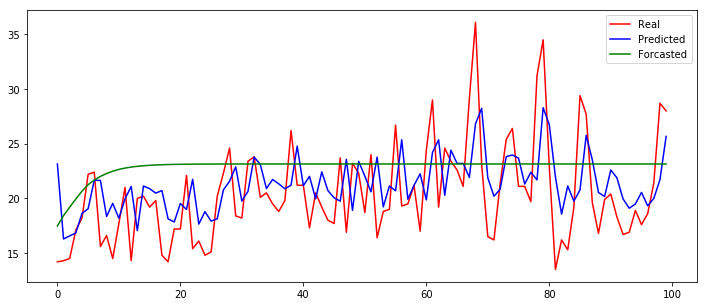

In [19]:
# Başlangıç Noktasından veriler alınır ve sırayla tahminleri hesaplanır.
selected_input = Xtest[beg:beg+100,:,:]
real_output = scaler.inverse_transform(Ytest[beg:beg+100])
predicted_output = model.predict(selected_input, batch_size=1)
predicted_output = scaler.inverse_transform(predicted_output)
# Sonuçlar Grafik halinde gösterilir.
print('Plotting Results')
plt.figure(figsize=(12,5))
xpos = range(len(predicted_output))
plt.plot(xpos,real_output,'r',xpos,predicted_output,'b',xpos,forcasted_output,'g')
plt.legend(('Real','Predicted','Forcasted'))
plt.savefig('out.jpg',dpi=400)
plt.show()